In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from ssqueezepy import cwt,icwt,Wavelet
from ssqueezepy.experimental import scale_to_freq
import obspy
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import ConnectionPatch
import sys
machine_epsilon = sys.float_info.epsilon


In [2]:
def gauss1(x, a1, b1, c1):
    return a1 * np.exp(-((x - b1)**2) / (2 * c1**2))


 
def zhang_thre(W,Lamda,A):
    WW_soft_new1=W.copy()
    WW_soft_new1_abs=np.abs(WW_soft_new1)
    for i in range(WW_soft_new1_abs.shape[0]):
        nn = WW_soft_new1_abs[i, :] >= Lamda[i]  
        WW_soft_new1_abs[i, nn]  = WW_soft_new1_abs[i, nn] -Lamda[i]*(A/(machine_epsilon+np.max(WW_soft_new1_abs[i, :])))**(1/2)
        nn = WW_soft_new1_abs[i, :] < Lamda[i]  
        WW_soft_new1_abs[i, nn]=0
    WW=WW_soft_new1_abs* WW_soft_new1/np.abs(machine_epsilon+WW_soft_new1)
    return WW



def cal_thre(W_abs):
    N=W_abs.shape[1]
    Lamda=np.zeros(W_abs.shape[0])
    for i in range(W_abs.shape[0]):
        Lamda[i]=np.median(W_abs[i,:]) / 0.6745 * np.sqrt(2 * np.log(N))/np.log2(i+1+1)
    return Lamda


In [ ]:

st = obspy.read("example.msd")
n=0
s=st[n].data[0:6001]
fs = st[n].stats.sampling_rate
N=len(s)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
nv = 10
wavelet = Wavelet(wavelet='morlet')
W,scales= cwt(s, wavelet=wavelet,nv=nv)# CWT
W_abs=np.abs(W)
freq = scale_to_freq(scales, wavelet, N, fs=fs)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
WW_abs=np.abs(W)
WW_abs=WW_abs+np.mean(WW_abs)
xu=np.linspace(0,W.shape[0]-1,W.shape[0])
pp=np.zeros(W.shape[0])
for i in range(W.shape[0]):
    prob_dist = WW_abs[i, :] / (np.sum(WW_abs[i, :]) + 1e-8)
    pp[i] = -np.sum(prob_dist * np.log(prob_dist + 1e-8))
pp=1-(pp-np.min(pp))/(np.max(pp)-np.min(pp))


xData = np.ravel(xu)
yData = np.ravel(pp)
mm = np.max(yData)   
nn_index = np.argmax(yData)       
b1_guess = xData[nn_index]        
c1_guess = (np.max(xData) - b1_guess) / 3  
initial_guess = [mm, b1_guess, c1_guess]
param_bounds = ([-np.inf, -np.inf, 0], [np.inf, np.inf, np.inf])
popt, pcov = curve_fit(gauss1, xData, yData, p0=initial_guess, bounds=param_bounds,maxfev=1000) 


a1_fit, b1_fit, c1_fit = popt
st1 = max(int(np.ceil(b1_fit - 3*c1_fit)), 0)
ed1 = min(int(np.floor(b1_fit + 3*c1_fit)), W.shape[0]-1)


W1=W[st1+1:ed1].copy()
W1_abs=np.abs(W1)
I=W1_abs.sum(axis=0)
I_min=np.min(I)
I_max=np.max(I)
I_norm=(I - I_min) / (I_max - I_min+machine_epsilon)
I_1=W1_abs.copy()

for i in range(W1.shape[0]):
    I_norm_1=I_norm.copy()
    W_abs_f=W1_abs[i,:]
    W_abs_f_min=np.min(W_abs_f)
    W_abs_f_max=np.max(W_abs_f)
    W_norm_f=(W_abs_f - W_abs_f_min) / (W_abs_f_max - W_abs_f_min+machine_epsilon)
    mask=I_norm_1>W_norm_f
    I_norm_1[mask]=W_norm_f[mask]
    I_1[i,:]=I_norm_1*(I_max - I_min)+I_min

W2=W1/(I_1+machine_epsilon)
W2_abs=np.abs(W2)
#-------------------------------------------------------------------
nk=100
curve=np.zeros((nk))
nnn=np.linspace(np.min(I_1), np.max(I_1),nk)
ik=0
for i in nnn:
    curve[ik]=np.sum(np.abs(W1_abs-i*W2_abs))
    if ik > 0:
        if curve[ik] > curve[ik - 1]:  
            break
    ik=ik+1
#-------------------------------------------------------------------
curve1=np.zeros((nk))
nnn1=np.linspace(nnn[np.max([ik-2,0])], nnn[ik],nk)
ik1=0
for i in nnn1:
    curve1[ik1]=np.sum(np.abs(W1_abs-i*W2_abs))
    if ik1 > 0:
        if curve1[ik1] > curve1[ik1 - 1]:  
            break
    ik1=ik1+1
k=nnn1[np.max(ik1-1,0)]
#-------------------------------------------------------------------
W2_k=W2*k
W2_kabs=np.abs(W2_k)
W3=W1-W2_k   
mask=W2_kabs>W1_abs  
W3[mask]=0
W3_abs=np.abs(W3)
W3=W3*np.max(I-I_min)/np.max(W3_abs.sum(axis=0))

W3_3=W.copy()
W3_3[:st1+1,:]=0
W3_3[ed1:,:]=0
W3_3[st1+1:ed1]=W3

Lamda=cal_thre(W_abs)
W_zhang=zhang_thre(W,Lamda,np.median(np.abs(s)))
w_zhang=icwt(W_zhang,wavelet=wavelet, nv=nv)

Xii=np.zeros(W.shape)
mask=(np.abs(W3_3)/W_abs>0)&(np.abs(W_zhang)/W_abs>0)
Xii[mask]=1
W4=Xii*W3_3
w2=icwt(W4,wavelet=wavelet, nv=nv)



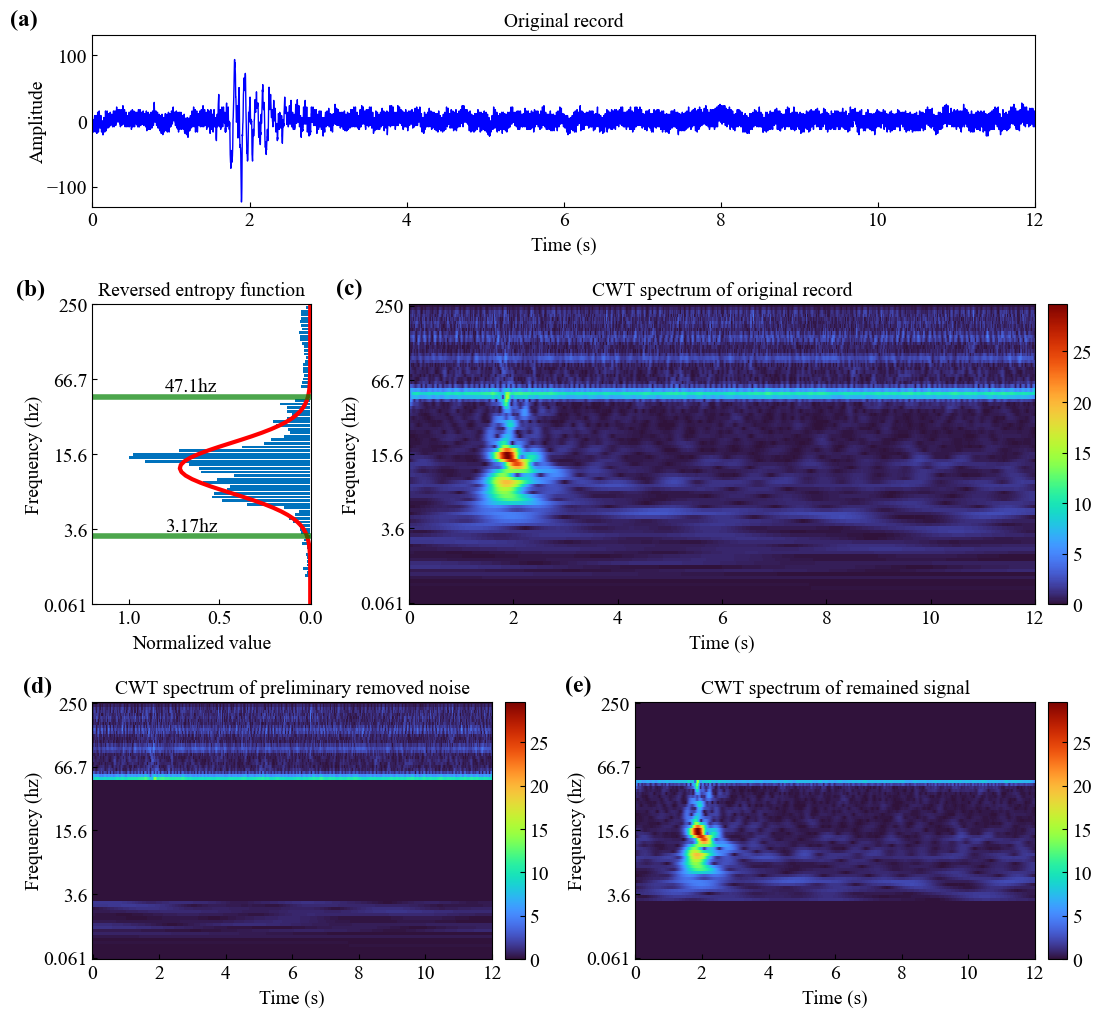

In [ ]:

NN=14
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = NN  
plt.rcParams['axes.labelsize'] = NN  
plt.rcParams['axes.titlesize'] = NN   
plt.rcParams['xtick.labelsize'] = NN  
plt.rcParams['ytick.labelsize'] = NN  
plt.rcParams['legend.fontsize'] = NN  
plt.rcParams['axes.labelpad'] =.1
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'  
selected_freq = freq[np.linspace(0, len(freq)-1, 5).astype(int)]
selected_scale = scales[np.linspace(0, len(scales)-1, 5).astype(int)]
formatted_labels = [f"{x:.3g}" for x in selected_freq]
formatted_scale  = [f"{x:.3g}" for x in selected_scale]
ln=1
nnu=5
n_h=1.4
tt = np.array([0, 1000,2000,3000,4000,5000,6000])
# tt=np.linspace(0, N, 10)
vm=np.max(W_abs)
wa1=[4,1,3,2,2]
ha1=[1,1.75,1.75,1.5,1.5]
fig = plt.figure(figsize=(13, 12))
gs = gridspec.GridSpec(3, 4*nnu+1, height_ratios=[1, 1.75,1.5], hspace=0.4,figure=fig)  
gs.update(right=0.85)  

ax1 = fig.add_subplot(gs[0, :])  
ax2 = fig.add_subplot(gs[1, 0:nnu])  
ax3 = fig.add_subplot(gs[1, nnu+2:])  
ax5 = fig.add_subplot(gs[2, 0:2*nnu-1])
ax7 = fig.add_subplot(gs[2, 2*nnu+2:])  



ax1.plot(s, color='blue', linewidth=ln, linestyle='-')
ax1.set_xlim([tt[0], tt[-1]])
ax1.set_xticks(tt)
ax1.set_xticklabels((tt/fs).astype(int))
ax1.set_ylim([-n_h*np.max(s), n_h*np.max(s)])
ax1.set_xlabel('Time (s)',labelpad=5)
ax1.set_ylabel('Amplitude')
ax1.set_title('Original record')




bars = ax2.barh(xData,yData,height=0.8, color='#0072BD', alpha=1, align='center')
# bars = ax2.barh(xData,yData)
ax2.plot(gauss1(xu, a1_fit, b1_fit, c1_fit), xu, 'r-', linewidth=3)#, label='Fitted Curve')
# ax2.plot(asymmetric_gaussian(xu, *popt_asym), xu, 'r-', linewidth=3)#, label='Fitted Curve')

# ax2.legend()   
ax2.axhline(y=st1+1, color='g', linewidth=4, alpha=0.7)
ax2.axhline(y=ed1-1, color='g', linewidth=4, alpha=0.7)

ax2.text(.8, st1+1-1.5,str(f"{freq[st1+1]:.3g}")+ "hz" )
ax2.text(.8, ed1-1-1.5,str(f"{freq[ed1-1]:.3g}")+ "hz" )


ax2.set_ylim([xu[0]-0, xu[-1]+0])
ax2.set_xlim(-0.005, 1.2*np.max(yData))
ax2.set_yticks(np.linspace(0, len(freq)-1, 5))
ax2.set_yticklabels(formatted_labels)
# ax1.grid(True, linestyle='--', alpha=0.5)
# ax2.set_title('Corr Distribution with Fitting', fontsize=12)
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.set_xlabel('Normalized value',labelpad=5)
ax2.set_ylabel('Frequency (hz)')
ax2.set_title('Reversed entropy function')

im = ax3.imshow(W_abs, aspect='auto', vmin=0, vmax=vm, cmap='turbo',interpolation='none')
# cbar_ax = plt.gcf().add_axes([0.865, 0.47, 0.015, 0.2305])  
# cbar = plt.colorbar(im, cax=cbar_ax)
ax_pos = ax3.get_position()
cbar_ax = plt.gcf().add_axes([ax_pos.x1+0.01, ax_pos.y0, 0.015, ax_pos.height])
cbar = plt.colorbar(im, cax=cbar_ax)
im.set_clim(0, vm)


# ax3.set_title('Matrix Visualization', fontsize=12)
ax3.set_xticks(tt)
ax3.set_xticklabels((tt/fs).astype(int))
ax3.set_yticks(np.linspace(0, len(freq)-1, 5))
ax3.set_yticklabels(formatted_labels)
# ax3.set_yticklabels(freq[np.linspace(0, len(freq)-1, 5).astype(int)].astype(int))
ax3.set_xlabel('Time (s)',labelpad=5)
ax3.set_ylabel('Frequency (hz)')
# ax3.set_ylabel('Scales',labelpad=-25)
ax3.set_title('CWT spectrum of original record')




WW=W.copy()
WW[st1+1:ed1]=WW[st1+1:ed1]-W1
im =ax5.imshow(np.abs(WW), aspect='auto', vmin=0, vmax=vm, cmap='turbo',interpolation='none')
ax_pos = ax5.get_position()
cbar_ax = plt.gcf().add_axes([ax_pos.x1+0.01, ax_pos.y0, 0.015, ax_pos.height])
cbar = plt.colorbar(im, cax=cbar_ax)
im.set_clim(0, vm)
ax5.set_xticks(tt)
ax5.set_xticklabels((tt/fs).astype(int))
# ax5.set_title('Matrix Visualization', fontsize=12)
ax5.set_yticks(np.linspace(0, len(freq)-1, 5))
ax5.set_yticklabels(formatted_labels)
ax5.set_xlabel('Time (s)',labelpad=5)
ax5.set_ylabel('Frequency (hz)')
ax5.set_title('CWT spectrum of preliminary removed noise')


W11=W.copy()
W11[:st1+1,:]=0
W11[ed1:,:]=0
W11[st1+1:ed1]=W1
im =ax7.imshow(np.abs(W11),aspect='auto', vmin=0, vmax=vm, cmap='turbo',interpolation='none')
ax_pos = ax7.get_position()
cbar_ax = plt.gcf().add_axes([ax_pos.x1+0.01, ax_pos.y0, 0.015, ax_pos.height])
cbar = plt.colorbar(im, cax=cbar_ax)
im.set_clim(0, vm)
ax7.set_xticks(tt)
ax7.set_xticklabels((tt/fs).astype(int))
ax7.set_yticks(np.linspace(0, len(freq)-1, 5))
ax7.set_yticklabels(formatted_labels)
# ax7.set_title('Matrix Visualization', fontsize=12)
ax7.set_xlabel('Time (s)',labelpad=5)
ax7.set_ylabel('Frequency (hz)')
ax7.set_title('CWT spectrum of remained signal')





labels = ['(a)', '(b)', '(c)','(d)','(e)']
for i, ax in enumerate([ax1, ax2, ax3,ax5,ax7]):
    ax.text(
        -0.35/wa1[i], 1+0.15/ha1[i], labels[i], 
        transform=ax.transAxes,  
        fontsize=NN+3,
        weight='bold',
        color='black',
        va='top',  
        ha='left'  
    )
# fig.align_labels() 
# plt.savefig("fig1.tif", dpi=650, format="tiff", bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})
plt.show()


In [ ]:

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

formatter1 = ScalarFormatter(useMathText=True)
formatter1.set_scientific(True)
formatter1.set_powerlimits((0, 0))

formatter_cbar = ScalarFormatter(useMathText=True)
formatter_cbar.set_scientific(True)
formatter_cbar.set_powerlimits((0, 0)) 

ln=1
NN=14

plt.rcParams['mathtext.fontset'] = 'custom'  # 
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'  # 


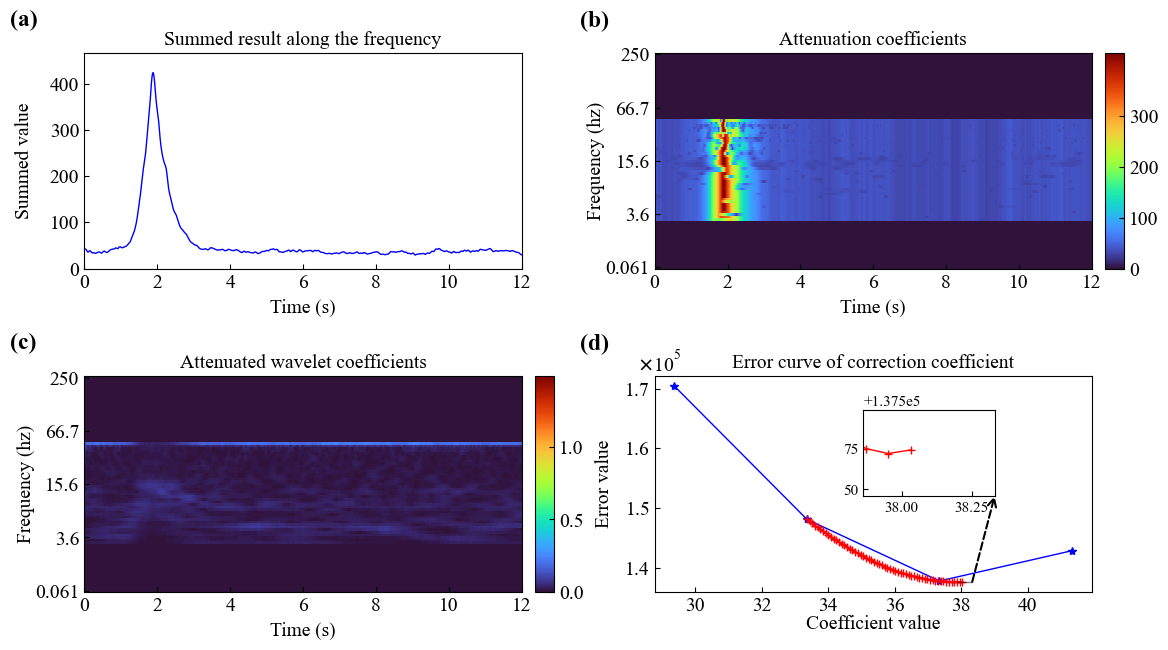

In [ ]:
plt.figure(figsize=(13, 7))
gs = gridspec.GridSpec(2, 9, height_ratios=[1, 1], hspace=0.5)
gs.update(right=0.9) 

# ax4 = plt.subplot(gs[0, 0:5])  
# ax1 = plt.subplot(gs[0, 6:])  
# ax2 = plt.subplot(gs[1, 0:5])  
# ax3 = plt.subplot(gs[1, 6:])

ax4 = plt.subplot(gs[0, 0:4])  
ax1 = plt.subplot(gs[0, 5:])  
ax2 = plt.subplot(gs[1, 0:4])  
ax3 = plt.subplot(gs[1, 5:])

WW_smw1=np.zeros(W.shape)
WW_smw1[st1+1:ed1]=I_1


im = ax1.imshow(WW_smw1, cmap='turbo', aspect='auto',interpolation='none')

ax1.set_xticks(tt)
ax1.set_xticklabels((tt/fs).astype(int))
ax1.set_yticks(np.linspace(0, len(freq)-1, 5))
ax1.set_yticklabels(formatted_labels)
ax1.set_xlabel('Time (s)',labelpad=5)
ax1.set_ylabel('Frequency (hz)')
ax1.set_title('Attenuation coefficients')

ax_pos = ax1.get_position()
cbar_ax = plt.gcf().add_axes([ax_pos.x1+0.01, ax_pos.y0, 0.015, ax_pos.height]) 
cbar=plt.colorbar(im, cax=cbar_ax)
cbar.set_ticks([0,100,200,300])
# cbar.ax.yaxis.set_major_formatter(formatter_cbar)
# cbar.ax.yaxis.offsetText.set_position((2.5, 1.02))  


W33=np.zeros(W.shape)
W33[st1+1:ed1]=np.abs(W2)

im2 = ax2.imshow(W33, aspect='auto',   vmin=0, vmax=vm/20, cmap='turbo',interpolation='none')
ax_pos = ax2.get_position()
cbar_ax = plt.gcf().add_axes([ax_pos.x1+0.01, ax_pos.y0, 0.015, ax_pos.height]) 
cbar = plt.colorbar(im2, cax=cbar_ax)

ax2.set_xticks(tt)
ax2.set_xticklabels((tt/fs).astype(int))
ax2.set_yticks(np.linspace(0, len(freq)-1, 5))
ax2.set_yticklabels(formatted_labels)
ax2.set_xlabel('Time (s)',labelpad=5)
ax2.set_ylabel('Frequency (hz)')
ax2.set_title('Attenuated wavelet coefficients')

ax3.plot(nnn[:ik+1],curve[:ik+1], 'b-*', linewidth=ln)
ax3.plot(nnn1[:ik1+1],curve1[:ik1+1],'r-+')
ax3.yaxis.set_major_formatter(formatter)
ax3.yaxis.offsetText.set_position((-0.04, 1.02))
ax3.set_xlabel('Coefficient value')
ax3.set_ylabel('Error value',labelpad=8)
ax3.set_title('Error curve of correction coefficient')

axins = inset_axes(
    ax3,
    width="30%", 
    height="40%",
    bbox_to_anchor=(-0.2, -0.11, 1, 1),  
    bbox_transform=ax3.transAxes  
)
axins.plot(nnn[:ik+1],curve[:ik+1], 'b-*', linewidth=ln)
axins.plot(nnn1[:ik1+1],curve1[:ik1+1], 'r-+', linewidth=ln)

sstt=ik-2
eedd=ik
det=2
axins.set_xlim(nnn[sstt]+det*2+.5,nnn[eedd]-det-1)  
axins.set_ylim(0.9985*np.min(curve[sstt:eedd+1]),0.92925*np.max(curve[sstt:eedd+1]))
# axins.yaxis.set_major_formatter(formatter1)
axins.yaxis.offsetText.set_position((0, 1.02))
axins.tick_params(axis='both', labelsize=NN-3)  
axins.yaxis.offsetText.set_fontsize(NN-3)
ax3.indicate_inset_zoom(axins, edgecolor="black")  
end_point = (nnn[eedd]-det-1,0.92925*np.max(curve[sstt:eedd+1])) 
start_point= (axins.get_xlim()[1], axins.get_ylim()[0])  
conn = ConnectionPatch(
    xyA=end_point,  
    xyB=start_point,  
    coordsA="data",  
    coordsB="data",
    axesA=ax3,     
    axesB=axins,       
    arrowstyle="->",   
    mutation_scale=15,  
    linewidth=1.5,    
    color="black",     
    linestyle="--"     
)
ax3.add_artist(conn)

ax4.plot(I, color='blue', linewidth=ln, linestyle='-')
ax4.set_xlim([tt[0], tt[-1]])
ax4.set_xticks(tt)
ax4.set_xticklabels((tt/fs).astype(int))
ax4.set_ylim([0, 1.1*I_max])
ax4.set_xlabel('Time (s)',labelpad=5)
ax4.set_ylabel('Summed value',labelpad=12)
ax4.set_title('Summed result along the frequency')



# plt.tight_layout()
labels = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate([ax4, ax1, ax2, ax3]):
    ax.text(
        -0.17, 1+0.2, labels[i], 
        transform=ax.transAxes,  
        fontsize=NN+3,
        weight='bold',
        color='black',
        va='top',  
        ha='left'  
    )

# plt.savefig("fig2.tif", dpi=650, format="tiff", bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})
plt.show()

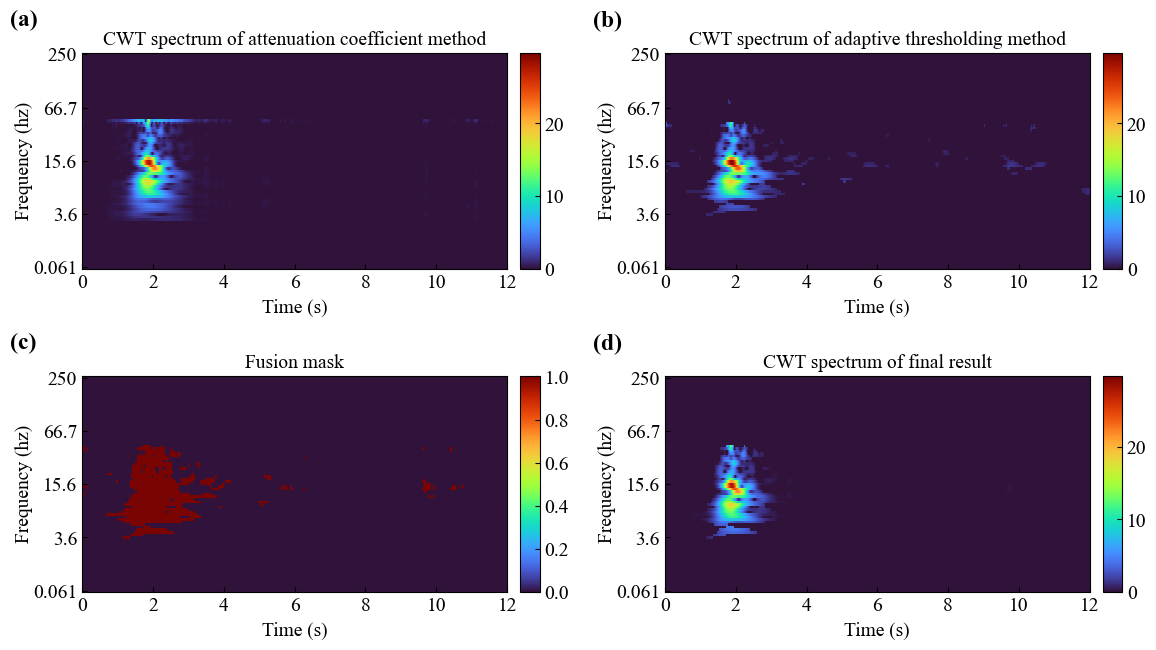

In [7]:
plt.figure(figsize=(13, 7))
gs = gridspec.GridSpec(2, 14, height_ratios=[1, 1], hspace=0.5)
gs.update(right=0.9) 

ax1 = plt.subplot(gs[0, 0:6])  
ax2 = plt.subplot(gs[0, 8:])  
ax4 = plt.subplot(gs[1, 0:6])  
ax3 = plt.subplot(gs[1, 8:])



im1 = ax1.imshow(np.abs(W3_3), aspect='auto',   vmin=0, vmax=vm, cmap='turbo',interpolation='none')
ax_pos = ax1.get_position()
cbar_ax = plt.gcf().add_axes([ax_pos.x1+0.01, ax_pos.y0, 0.015, ax_pos.height]) 
cbar = plt.colorbar(im1, cax=cbar_ax)
ax1.set_xticks(tt)
ax1.set_xticklabels((tt/fs).astype(int))
ax1.set_yticks(np.linspace(0, len(freq)-1, 5))
ax1.set_yticklabels(formatted_labels)
ax1.set_xlabel('Time (s)',labelpad=5)
ax1.set_ylabel('Frequency (hz)')
ax1.set_title("CWT spectrum of attenuation coefficient method")

im2 = ax2.imshow(np.abs(W_zhang), aspect='auto',   vmin=0, vmax=vm, cmap='turbo',interpolation='none')
ax_pos = ax2.get_position()
cbar_ax = plt.gcf().add_axes([ax_pos.x1+0.01, ax_pos.y0, 0.015, ax_pos.height]) 
cbar = plt.colorbar(im2, cax=cbar_ax)
ax2.set_xticks(tt)
ax2.set_xticklabels((tt/fs).astype(int))
ax2.set_yticks(np.linspace(0, len(freq)-1, 5))
ax2.set_yticklabels(formatted_labels) 
ax2.set_xlabel('Time (s)',labelpad=5)
ax2.set_ylabel('Frequency (hz)')
ax2.set_title("CWT spectrum of adaptive thresholding method")

im3 = ax3.imshow(np.abs(W4), aspect='auto',   vmin=0, vmax=vm, cmap='turbo',interpolation='none')
ax_pos = ax3.get_position()
cbar_ax = plt.gcf().add_axes([ax_pos.x1+0.01, ax_pos.y0, 0.015, ax_pos.height]) 
cbar = plt.colorbar(im3, cax=cbar_ax)
ax3.set_xticks(tt)
ax3.set_xticklabels((tt/fs).astype(int))
ax3.set_yticks(np.linspace(0, len(freq)-1, 5))
ax3.set_yticklabels(formatted_labels)
ax3.set_xlabel('Time (s)',labelpad=5)
ax3.set_ylabel('Frequency (hz)')
ax3.set_title('CWT spectrum of final result')
# ax3.set_title('Result of Mask Fusion')


im4 = ax4.imshow(np.abs(Xii), aspect='auto',  cmap='turbo',interpolation='none')
ax_pos = ax4.get_position()
cbar_ax = plt.gcf().add_axes([ax_pos.x1+0.01, ax_pos.y0, 0.015, ax_pos.height]) 
cbar = plt.colorbar(im4, cax=cbar_ax)
ax4.set_xticks(tt)
ax4.set_xticklabels((tt/fs).astype(int))
ax4.set_yticks(np.linspace(0, len(freq)-1, 5))
ax4.set_yticklabels(formatted_labels)
ax4.set_xlabel('Time (s)',labelpad=5)
ax4.set_ylabel('Frequency (hz)')
ax4.set_title('Fusion mask')



# plt.tight_layout()
labels = ['(a)', '(b)', '(d)', '(c)']
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.text(
        -0.17, 1+0.2, labels[i], 
        transform=ax.transAxes,  
        fontsize=NN+3,
        weight='bold',
        color='black',
        va='top',  
        ha='left'  
    )

# plt.savefig("fig3.tif", dpi=650, format="tiff", bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})
plt.show()

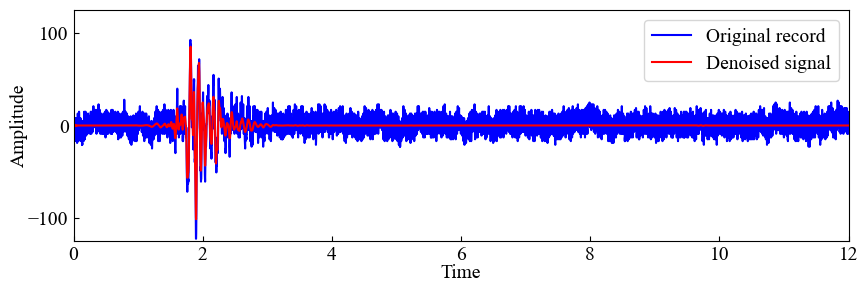

In [ ]:


formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

formatter1 = ScalarFormatter(useMathText=True)
formatter1.set_scientific(True)
formatter1.set_powerlimits((0, 0))

formatter_cbar = ScalarFormatter(useMathText=True)
formatter_cbar.set_scientific(True)
formatter_cbar.set_powerlimits((0, 0)) 

ln=1
NN=10

plt.rcParams['mathtext.fontset'] = 'custom'  
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'  
vmiw = -np.max(np.abs(s))*1.02
vmaw = np.max(np.abs(s))*1.02
t=np.linspace(0,len(s)-1,len(s))/fs

plt.figure(figsize=(10, 3))

plt.plot(t,s,'b', label='Original record')
plt.plot(t, w2,'r', label='Denoised signal')
plt.xlim(t[0],t[-1])
plt.ylim(vmiw,vmaw)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()



# plt.savefig("fig4.tif", dpi=650, format="tiff", bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})
plt.show()